<a href="https://colab.research.google.com/github/diegoturenne/Application-Oriented-Deep-Learning-Course-2022-UU/blob/main/Copy_of_Exercise_6_4_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exercise 6.4**

MNIST with fully connected networks and grid/random search

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tabulate import tabulate
from tensorflow.keras import layers
from tensorflow import keras


The MNIST data base of handwritten numbers is directly available through KERAS. The following codeblocks download and preprocess the data. 

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Hint: convert integer RGB values (0-255) to float values (0-1)
# comment: if you have only one value like here, it seems to be greyscale, not RGB ... 
x_valid = x_test[8000:]/255
y_valid = y_test[8000:]
x_test = x_test[:8000]/255
y_test = y_test[:8000]

#forgot this :
x_train = x_train / 255


In [ ]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28)
60000 train samples
2000 validation samples
8000 test samples


In this exercise, a fully connected neural network is used to predict the handwritten numbers. To do this, we reformat the pictures with 28x28 pixels into a vector with a length of 28x28=784.

In [ ]:
# reshape the image matrices to vectors
x_train = x_train.reshape(-1, 28**2)
x_valid = x_valid.reshape(-1, 28**2)
x_test = x_test.reshape(-1, 28**2)
print("x_train shape:", x_train.shape)

x_train shape: (60000, 784)


We use "onehot" encoding of the classes. This means a "zero" is encoded as `[1,0,0,0,0,0,0,0,0,0]` and a "one" as `[0,1,0,0,0,0,0,0,0,0]` etc. 
This is done because our network will have ten output nodes with the output node with the largest value being the predicted number.

In [ ]:
# convert class vectors to binary class matrices (10 numbers/classes)
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, 10)
y_test_onehot  = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
y_test_onehot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
# define model here
model = tf.keras.models.Sequential([
    # layers.Dense(128, input_shape=(784,) ),
    layers.Dense(128, input_shape=(784,), activation = 'relu'),
    layers.Dropout(rate=0.2), 
    layers.Dense(10),
    layers.Activation('softmax')])  # softmax actication to transform output into probabiliites

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.01) 
model.compile(
    loss='categorical_crossentropy',  # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
    optimizer=adam,
    metrics=['accuracy']) # we use accuracy to quanitfy to network performance. 

# define callbacks for training
save_best = tf.keras.callbacks.ModelCheckpoint(
    "best_model_{}.h5".format(model.name),
    save_best_only=True,
    monitor="val_accuracy",
    save_weights_only=True,
)

# Keras calculates training accuracy and loss during the training and with regularization applied,
# while the validation metrics are calculated at the end of each epoch.
# This callback calculates the training metrics the same way as for the validation
class CalculateMetrics(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=0)
        logs["train_loss"] = train_loss
        logs["train_acc"] = train_acc

results = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),
    
    batch_size=32, # we googled a bit and lower batch nb seem to be better to reduce generalisation errors
    epochs=9,
    callbacks=[
        save_best,
        CalculateMetrics(),
        tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))
    ]
    )

Epoch 1/9
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3114 - accuracy: 0.9089 - val_loss: 0.1138 - val_accuracy: 0.9695 - train_loss: 0.1687 - train_acc: 0.9527
Epoch 2/9
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2462 - accuracy: 0.9312 - val_loss: 0.1255 - val_accuracy: 0.9685 - train_loss: 0.1324 - train_acc: 0.9615
Epoch 3/9
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2270 - accuracy: 0.9377 - val_loss: 0.1099 - val_accuracy: 0.9675 - train_loss: 0.1335 - train_acc: 0.9615
Epoch 4/9
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2161 - accuracy: 0.9438 - val_loss: 0.1419 - val_accuracy: 0.9710 - train_loss: 0.1231 - train_acc: 0.9653
Epoch 5/9
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2042 - accuracy: 0.9461 - val_loss: 0.1038 - val_accuracy: 0.9755 - train_loss: 0.0963 - train_acc: 0.9712
Epoch 6/9
1875/1875 [==============================] - 10s 5ms/step - loss: 

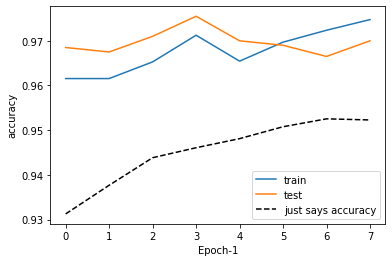

In [ ]:
# load best model
model.load_weights(f"best_model_{model.name}.h5")

# ------------------------
# ---     Plotting     ---
# ------------------------

# plot training history
history = np.genfromtxt(f"history_{model.name}.csv", delimiter=",", names=True)



train_acc = history['train_acc'][1:]
test_acc = history['val_accuracy'][1:]

# add plots below
plt.plot(train_acc,label="train")
plt.plot(test_acc,label="test")
plt.plot(history['accuracy'][1:], ls='--', c='k', label='just says accuracy')
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("accuracy")
plt.show()

In [ ]:
# evaluate performance

print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

table = [
    ["Train", *model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128)[1])*100 ],
    ["Validation", *model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128)[1])*100 ],
    ["Test", *model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1])*100 ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.0963363 |   0.97125  |                2.875  |
| Validation | 0.103794  |   0.9755   |                2.45   |
| Test       | 0.167716  |   0.958375 |                4.1625 |


You can compare your own results with a variety of different models: http://yann.lecun.com/exdb/mnist/ and https://en.wikipedia.org/wiki/MNIST_database

The following codeblocks define some helper functions for plotting. You don't need to touch them

In [ ]:
#@title
def plot_image(X, ax=None):                                                                                                                                    
    """Plot an image X.                                                                                                                                        
                                                                                                                                                               
    Args:                                                                                                                                                      
        X (2D array): image, grayscale or RGB                                                                                                                  
        ax (None, optional): Description                                                                                                                       
    """                                                                                                                                                        
    if ax is None:                                                                                                                                             
        ax = plt.gca()                                                                                                                                         
                                                                                                                                                               
    if (X.ndim == 2) or (X.shape[-1] == 1):                                                                                                                    
        ax.imshow(X.astype('uint8'), origin='upper', cmap=plt.cm.Greys)                                                                                        
    else:                                                                                                                                                      
        ax.imshow(X.astype('uint8'), origin='upper')                                                                                                           
                                                                                                                                                               
    ax.set(xticks=[], yticks=[]) 

def plot_prediction(Yp, X, y, classes=None, top_n=False):                                                                                          
    """Plot an image along with all or the top_n predictions.                                                                                                  
                                                                                                                                                               
    Args:                                                                                                                                                      
        Yp (1D array): predicted probabilities for each class                                                                                                  
        X (2D array): image                                                                                                                                    
        y (integer): true class label                                                                                                                          
        classes (1D array, optional): class names                                                                                                              
        top_n (int, optional): number of top predictions to show
    """                                                                                                                                                        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.2))                                                                                                     
    plt.subplots_adjust(left=0.02, right=0.98, bottom=0.15, top=0.98, wspace=0.02)                                                                             
    plot_image(X, ax1)                                                                                                                                         
                                                                                                                                                               
    if top_n:                                                                                                                                                  
        n = top_n                                                                                                                                              
        s = np.argsort(Yp)[-top_n:]                                                                                                                            
    else:                                                                                                                                                      
        n = len(Yp)                                                                                                                                            
        s = np.arange(n)[::-1]                                                                                                                                 
                                                                                                                                                               
    patches = ax2.barh(np.arange(n), Yp[s], align='center')                                                                                                    
    ax2.set(xlim=(0, 1), xlabel='Probability', yticks=[])                                                                                                      
                                                                                                                                                               
    for iy, patch in zip(s, patches):                                                                                                                          
        if iy == y:                                                                                                                                            
            patch.set_facecolor('C1')  # color correct patch                                                                                                   
                                                                                                                                                               
    if classes is None:                                                                                                                                        
        classes = np.arange(0, np.size(Yp))                                                                                                                    
                                                                                                                                                               
    for i in range(n):                                                                                                                                         
        ax2.text(0.05, i, classes[s][i], ha='left', va='center')                                                                                               
                                                                                                                                                               
    plt.show()

def plot_confusion(yp, y, classes=None, fname=None):                                                                                                           
    """Plot confusion matrix for given true and predicted class labels                                                                                         
                                                                                                                                                               
    Args:                                                                                                                                                      
        yp (1D array): predicted class labels                                                                                                                  
        y (1D array): true class labels                                                                                                                        
        classes (1D array): class names                                                                                                                        
        fname (str, optional): filename for saving the plot                                                                                                    
    """                                                                                                                                                        
    if classes is None:                                                                                                                                        
        n = max(max(yp), max(y)) + 1                                                                                                                           
        classes = np.arange(n)                                                                                                                                 
    else:                                                                                                                                                      
        n = len(classes)                                                                                                                                       
                                                                                                                                                               
    bins = np.linspace(-0.5, n - 0.5, n + 1)                                                                                                                   
    C = np.histogram2d(y, yp, bins=bins)[0]                                                                                                                    
    C = C / np.sum(C, axis=0) * 100                                                                                                                            
                                                                                                                                                               
    fig = plt.figure(figsize=(8, 8))                                                                                                                           
    plt.imshow(C, interpolation='nearest', vmin=0, vmax=100, cmap=plt.cm.YlGnBu)                                                                               
    plt.gca().set_aspect('equal')                                                                                                                              
    cbar = plt.colorbar(shrink=0.8)                                                                                                                            
    cbar.set_label('Frequency %')                                                                                                                              
    plt.xlabel('Prediction')                                                                                                                                   
    plt.ylabel('Truth')                                                                                                                                        
    plt.xticks(range(n), classes, rotation='vertical')                                                                                                         
    plt.yticks(range(n), classes)                                                                                                                              
    for x in range(n):                                                                                                                                         
        for y in range(n):                                                                                                                                     
            if np.isnan(C[x, y]):                                                                                                                              
                continue                                                                                                                                       
            color = 'white' if x == y else 'black'                                                                                                             
            plt.annotate('%.1f' % (C[x, y]), xy=(y, x), color=color, ha='center', va='center')                                                                 
                                                                                                                                                               
    plt.show()

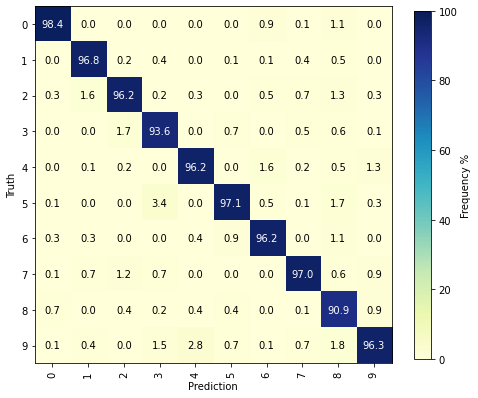

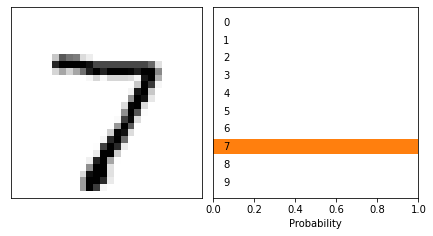

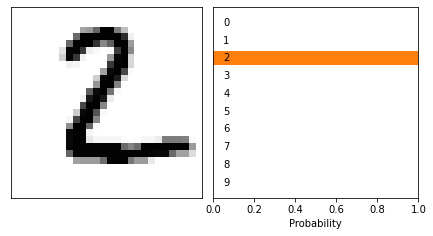

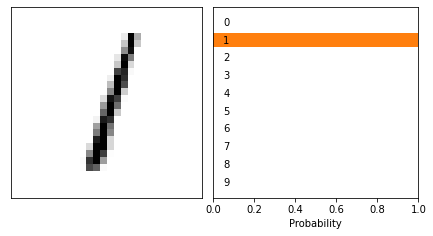

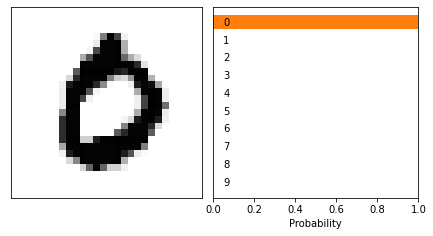

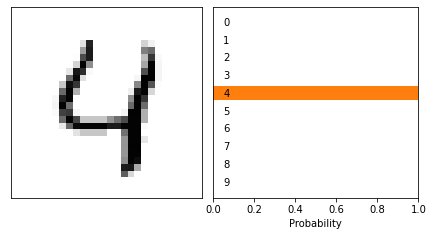

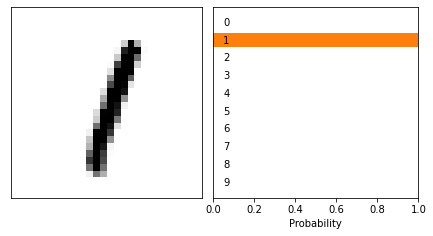

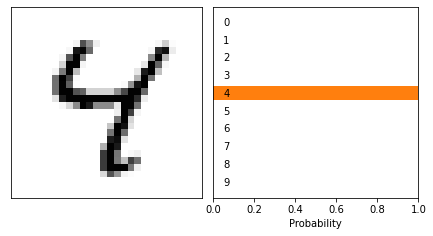

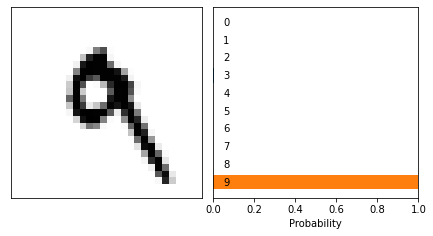

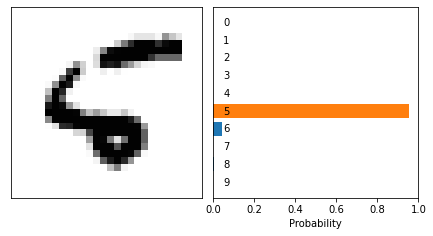

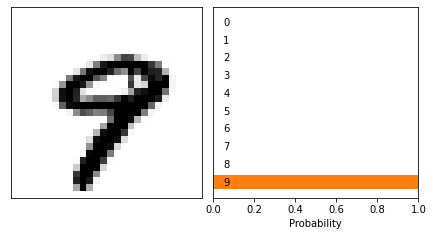

In [ ]:
# plot a few examples, loop over test dataset:
# get missidentified samples
output = model.predict(x_test, batch_size=128)
labels = np.argmax(y_test_onehot, axis=1)
predictions = np.argmax(output, axis=1)
plot_confusion(predictions, labels)

for i in range(10): # loop over first 10 test samples
    plot_prediction(output[i], 
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])
    

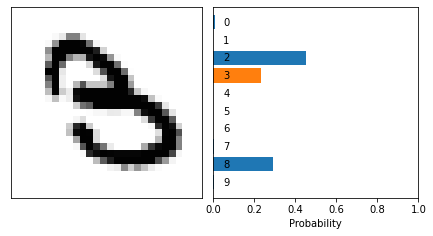

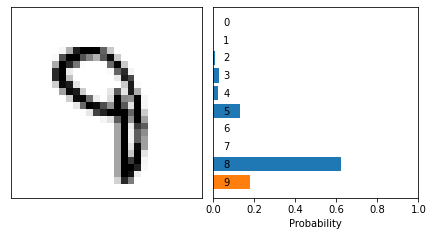

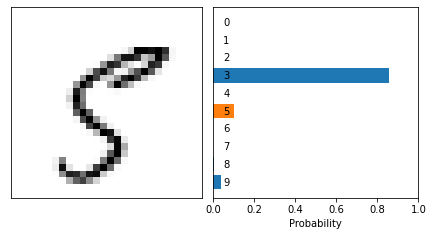

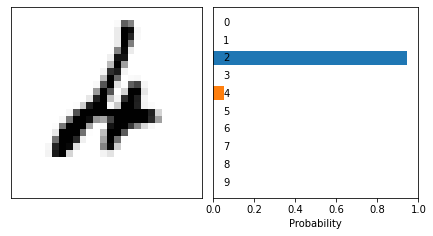

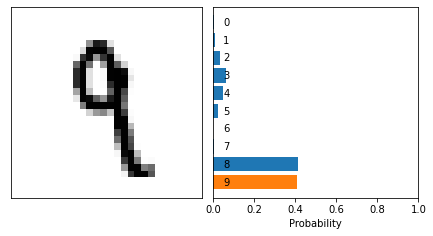

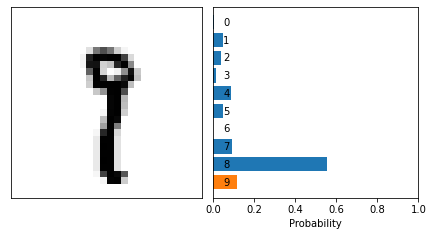

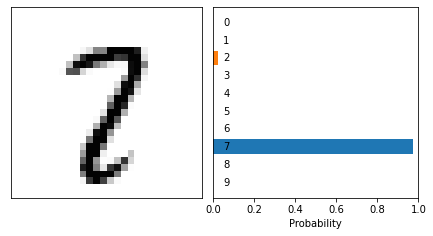

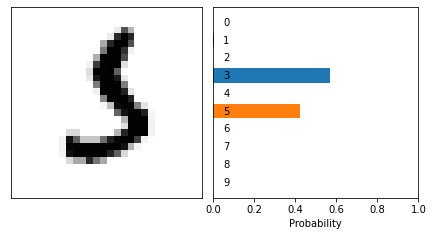

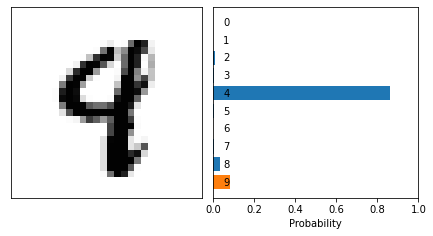

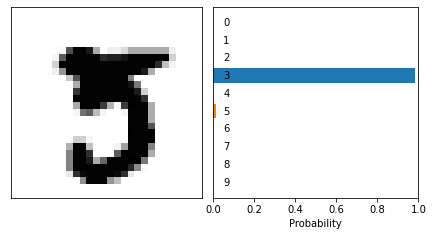

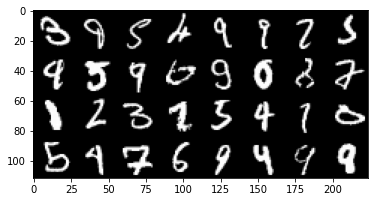

In [ ]:
# now plot a few examples that were misclassified

indices_miss = np.nonzero(predictions != labels)[0]
x_missid = x_test[indices_miss]

for i in indices_miss[:10]:
    plot_prediction(output[i], 
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])

# or plot 32 of them in a joint plot
fig = plt.figure()
ax = fig.add_subplot(111)
plotdata = x_missid[:32]
plotdata = np.hstack(np.concatenate(np.reshape(plotdata, (4, 8, 28, 28)), axis=1))
ax.imshow(plotdata, cmap="gray")


**Grid search**

Let's search the two hyperparameters dropout and number of nodes. You can start from the template below. 



In [ ]:
# # define model here
# # model = tf.keras.models.Sequential([
#     # layers.Dense(128, input_shape=(784,)),
#     layers.Dropout(rate=0.1), 
#     layers.Dense(10),
#     layers.Activation('softmax')])  # softmax actication to transform output into probabiliites

# print(model.summary())

In [ ]:
dropout_values = np.asarray([0.1, 0.5, 0.8])
n_neurons_values = np.asarray([64, 128, 256])
results_gridsearch = np.zeros((len(dropout_values), len(n_neurons_values), 2))
for iDrop, drop in enumerate(dropout_values):
  for iN, n_neurons in enumerate(n_neurons_values):
    print('execution nb:')
    print(iDrop + iN)

    model = tf.keras.models.Sequential([
        layers.Dense(n_neurons, input_shape=(784,)),
        layers.Dropout(rate=drop), 
        layers.Dense(10),
        layers.Activation('softmax')])  # softmax actication to transform output into probabiliites
    print('model good')
    model.compile(
        loss='categorical_crossentropy',  # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
        optimizer = adam, # WHY IS THERE A PARENTHESIS THERE !!!! IS THIS ALSO PART OF THE EXRECISE ? DID SOMEONE PROFFREAD THIS ? 
        metrics=['accuracy']) # we use accuracy to quanitfy to network performance. 
    print('compile good')

    results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=16,
        epochs=10,
        verbose=0
        )
    print('fit good, \n')
    t = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)
    results_gridsearch[iDrop, iN] = t
    print(f"dropout = {drop:.2f}, {n_neurons} neurons -> accuracy {results_gridsearch[iDrop, iN][1]:.3f}, error rate = {100*(1-results_gridsearch[iDrop, iN][1]):.1f}%")


execution nb:
0
model good
compile good
fit good, 

dropout = 0.10, 64 neurons -> accuracy 0.106, error rate = 89.4%
execution nb:
1
model good
compile good
fit good, 

dropout = 0.10, 128 neurons -> accuracy 0.215, error rate = 78.5%
execution nb:
2
model good
compile good
fit good, 

dropout = 0.10, 256 neurons -> accuracy 0.517, error rate = 48.3%
execution nb:
1
model good
compile good
fit good, 

dropout = 0.50, 64 neurons -> accuracy 0.286, error rate = 71.4%
execution nb:
2
model good
compile good
fit good, 

dropout = 0.50, 128 neurons -> accuracy 0.527, error rate = 47.3%
execution nb:
3
model good
compile good
fit good, 

dropout = 0.50, 256 neurons -> accuracy 0.669, error rate = 33.1%
execution nb:
2
model good
compile good
fit good, 

dropout = 0.80, 64 neurons -> accuracy 0.199, error rate = 80.1%
execution nb:
3
model good
compile good
fit good, 

dropout = 0.80, 128 neurons -> accuracy 0.624, error rate = 37.6%
execution nb:
4
model good
compile good
fit good, 

dropout

Comment: the more errors and dropout, the better .... 

**Random seach**

Now lets implement a random search. A random search allows us to scan more hyperparameters at once without more computing time. You can start from the template below. 




In [ ]:
# define model here
model = tf.keras.models.Sequential([
    layers.Dense(128, input_shape=(784,)),
    layers.Dropout(rate=0.2), 
    layers.Dense(10),
    layers.Activation('softmax')])  # softmax actication to transform output into probabiliites


adam = keras.optimizers.Adam(learning_rate=0.01) 
model.compile(
    loss='categorical_crossentropy',  # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
    optimizer=adam,
    metrics=['accuracy']) # we use accuracy to quanitfy to network performance. 

# define callbacks for training
save_best = tf.keras.callbacks.ModelCheckpoint(
    "best_model_{}.h5".format(model.name),
    save_best_only=True,
    monitor="val_accuracy",
    save_weights_only=True,
)


In [ ]:
N = 20 # number of trials 
search = {
'batch_size': np.random.choice([16, 32, 64, 128, 256], N),
'num_neurons': np.random.choice([8, 32, 128, 256, 512], N),
'learn_rate': np.random.choice([1e-5,1e-4, 1e-3, 1e-2, 1e-1],N),
'activation': np.random.choice(['relu', 'elu', 'sigmoid', 'tanh'], N),
'dropout': np.random.choice([0.0, 0.1, 0.2, 0.3, 0.5, 0.6], N),
'val_acc': np.zeros(N)
}

for i in range(N):
  # you can access the current value of the hyperparameter with `search['batch_size'][i]`
  adam = keras.optimizers.Adam(learning_rate=search['learn_rate'][i]) 

  model = tf.keras.models.Sequential([
                      tf.keras.layers.Dense(search['num_neurons'][i], activation = search['activation'][i] ,input_shape=(784,)),
                      layers.Dropout(rate=search['dropout'][i]), 
                      tf.keras.layers.Dense(10, activation='softmax')])
  
  model.compile(loss='categorical_crossentropy',
  optimizer= adam,)

  results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=search['batch_size'][i],
        epochs=10,
        verbose=0
      )
  
  search['val_acc'][i] = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)#[1] #What is this  "[1]" 1 doing there ? it throws error ! 
  print(f"iteration {i}:")#also: what does this evaluarion has to do with the error in the results !? 
  for key in search:
    print(f"\t{key}: {search[key][i]}")
  print(f"\t-> accuracy {search['val_acc'][i]:.3f}, error rate = {100*(1-search['val_acc'][i]):.1f}%")


iteration 0:
	batch_size: 32
	num_neurons: 128
	learn_rate: 1e-05
	activation: sigmoid
	dropout: 0.5
	val_acc: 1.854697823524475
	-> accuracy 1.855, error rate = -85.5%
iteration 1:
	batch_size: 256
	num_neurons: 32
	learn_rate: 0.001
	activation: elu
	dropout: 0.2
	val_acc: 2.1605710983276367
	-> accuracy 2.161, error rate = -116.1%
iteration 2:
	batch_size: 64
	num_neurons: 32
	learn_rate: 0.0001
	activation: elu
	dropout: 0.5
	val_acc: 2.1391611099243164
	-> accuracy 2.139, error rate = -113.9%
iteration 3:
	batch_size: 256
	num_neurons: 512
	learn_rate: 0.001
	activation: tanh
	dropout: 0.0
	val_acc: 0.22785837948322296
	-> accuracy 0.228, error rate = 77.2%
iteration 4:
	batch_size: 128
	num_neurons: 128
	learn_rate: 1e-05
	activation: elu
	dropout: 0.2
	val_acc: 1.674184799194336
	-> accuracy 1.674, error rate = -67.4%
iteration 5:
	batch_size: 64
	num_neurons: 512
	learn_rate: 1e-05
	activation: sigmoid
	dropout: 0.3
	val_acc: 1.6696134805679321
	-> accuracy 1.670, error rate = 

It's 7 min to 12... We can't find the bug that gives specific, negative values in this cell... 
the parameters that make the most sence gere are: 

batch_size: 16 \\
num_neurons: 256 \\
learn_rate: 0.01 \\
activation: tanh\\
dropout: 0.0\\
val_acc: 0.8808887600898743 \\
accuracy 0.881, error rate = 11.9 \\


A big enough number of neurons gives coherent resulrs, smaller batches tend to give better accuracy. 





